In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output
# import quantstats as qs
import os

In [2]:
from data_interaction import select_data_subset, add_lin_reg_prediction, add_price_diff_metric, Company_Data_Getter
from trading_classes import Position, Portfolio
import stock_picking
from stock_picking import best_on_date
import trading_history

In [3]:
base_dir = os.getcwd()
print(base_dir)
file_path = os.path.abspath(os.path.join(base_dir, '..', 'data'))
print(file_path)

c:\Users\matth\codeProjects\union_sif_quant_trading\backtesting
c:\Users\matth\codeProjects\union_sif_quant_trading\data


In [4]:
stock_data = pd.read_parquet(file_path+'\\stock_price_data\\all_data_processed_2024-09-28_after_1990.parquet')
display(stock_data.info())
display(stock_data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8752 entries, 1990-01-02 to 2024-09-27
Columns: 140640 entries, ('Adj_Close', 'AACG') to ('Size_Category', 'ZYXI')
dtypes: float64(134988), int64(30), object(5622)
memory usage: 9.2+ GB


None

Adj_Close                                                        \
                AACG   AACT  AAME    AAN        AAT  ABAT       ABCB  ABCL   
Date                                                                         
2024-09-23      0.63  10.80  1.58  10.06  27.120001  0.89  63.709999  2.48   
2024-09-24      0.68  10.81  1.59  10.06  27.320000  0.87  62.340000  2.52   
2024-09-25      0.73  10.80  1.56  10.03  27.040001  0.81  61.240002  2.44   
2024-09-26      0.72  10.81  1.61  10.03  26.490000  0.94  61.459999  2.56   
2024-09-27      0.73  10.83  1.68  10.05  26.570000  0.98  61.320000  2.61   

                               ... Size_Category                              \
                   ABG   ABTS  ...           ZTS   ZUMZ    ZUO   ZURA   ZVIA   
Date                           ...                                             
2024-09-23  227.949997  0.490  ...         large  small  small  small  micro   
2024-09-24  230.240005  0.500  ...         large  small  small  small  micro   
2024-09-25  231.699997  0.500  ...         large  small  small  micro  micro   
2024-09-26  238.210007  0.499  ...         large  small  small  small  micro   
2024-09-27  244.350006  0.513  ...         large  small  small  small  micro   

                                             
             ZVRA   ZVSA  ZWS   ZYME   ZYXI  
Date                                         
2024-09-23  small  micro  mid  small  small  
2024-09-24  small  micro  mid  small  small  
2024-09-25  small  micro  mid  small  small  
2024-09-26  small  micro  mid  small  small  
2024-09-27  small  micro  mid  small  small  

[5 rows x 140640 columns]

In [5]:
# read company data
company_data = pd.read_csv(file_path+'\\company_data\\company_data_cleaned_2024-09-29.csv',index_col=0)
company_data.head()

,Name,Last_Sale,Net_Change,Percent_Change,Market_Cap,Country,IPO_Year,Volume,Sector,Industry,Exchange
Ticker,,,,,,,,,,,
A,Agilent Technologies Inc. Common Stock,$148.06,1.3200,0.90%,4.254173e+10,United States,1999.0,2212993,Industrials,Biotechnology: Laboratory Analytical Instruments,NYSE
AA,Alcoa Corporation Common Stock,$39.27,-0.0100,-0.025%,1.014502e+10,United States,2016.0,5629158,Industrials,Aluminum,NYSE
AACG,ATA Creativity Global American Depositary Shares,$0.7302,0.0078,1.08%,2.336650e+07,China,2008.0,26100,Real Estate,Other Consumer Services,NASDAQ
AACT,Ares Acquisition Corporation II Class A Ordina...,$10.8299,0.0199,0.184%,0.000000e+00,NaN,2023.0,2476,Finance,Blank Checks,NYSE
AADI,Aadi Bioscience Inc. Common Stock,$1.93,0.0200,1.047%,4.750663e+07,United States,NaN,81024,Health Care,Biotechnology: Pharmaceutical Preparations,NASDAQ


In [6]:
company_data_getter_obj = Company_Data_Getter(stock_data=stock_data,company_data=company_data)

In [7]:
# SPY started trading in january 1993
# Since SPY is our benchmark, we're starting here

stock_data = select_data_subset(
    input_dataframe=stock_data,
    std_dev_day_range=[30, 60],
    reg_day_range=[30, 60],
    # ticker_subset=['AAPL', 'CMI', 'SLB'],
    price_vars_to_exclude=['Open','Close','High','Low'],
    start_date='1993-06-01'
)
display(stock_data.info())
display(stock_data)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7888 entries, 1993-06-02 to 2024-09-27
Columns: 61319 entries, ('Std_Dev_60', 'SANM') to ('Size_Category', 'AITRR')
dtypes: float64(55667), int64(30), object(5622)
memory usage: 3.6+ GB


None

Std_Dev_60 Intercept_30 Std_Dev_60 Adj_Close    Market_Cap  \
                 SANM         BFRI       BIRK      TROO          AUUD   
Date                                                                    
1993-06-02        NaN          NaN        NaN       NaN           NaN   
1993-06-03        NaN          NaN        NaN       NaN           NaN   
1993-06-04        NaN          NaN        NaN       NaN           NaN   
1993-06-07        NaN          NaN        NaN       NaN           NaN   
1993-06-08        NaN          NaN        NaN       NaN           NaN   
...               ...          ...        ...       ...           ...   
2024-09-23   2.969735   697.677064   5.292231      3.11  4.405170e+06   
2024-09-24   2.934463   696.772254   5.342270      2.97  4.104689e+06   
2024-09-25   2.912563   695.889500   5.374960      3.06  3.855233e+06   
2024-09-26   2.878914   695.022125   5.418156      3.01  3.872241e+06   
2024-09-27   2.843860   694.128279   5.451671      3.48  3.781530e+06   

           Std_Dev_30 Intercept_60 Intercept_30  Adj_Close  \
                 POAI           YQ         AKRO        FMC   
Date                                                         
1993-06-02        NaN          NaN          NaN   4.332693   
1993-06-03        NaN          NaN          NaN   4.261665   
1993-06-04        NaN          NaN          NaN   4.178799   
1993-06-07        NaN          NaN          NaN   4.214314   
1993-06-08        NaN          NaN          NaN   4.178799   
...               ...          ...          ...        ...   
2024-09-23   0.036615  2020.234795    -1.665180  63.560001   
2024-09-24   0.040273  2018.291995    -2.106176  64.650002   
2024-09-25   0.043807  2016.352034    -2.576878  63.970001   
2024-09-26   0.046100  2014.441495    -2.967226  65.970001   
2024-09-27   0.052587  2012.517849    -3.653426  66.080002   

           Dates_Numeric_Coeff_30  ... Size_Category Std_Dev_30 Size_Category  \
                             NERV  ...          MRNO        CPT           CXT   
Date                               ...                                          
1993-06-02                    NaN  ...          None        NaN         micro   
1993-06-03                    NaN  ...          None        NaN         small   
1993-06-04                    NaN  ...          None        NaN         micro   
1993-06-07                    NaN  ...          None        NaN         small   
1993-06-08                    NaN  ...          None        NaN         micro   
...                           ...  ...           ...        ...           ...   
2024-09-23              -0.013157  ...         small   2.375587           mid   
2024-09-24              -0.013153  ...         small   2.402921           mid   
2024-09-25              -0.013150  ...         small   2.396871           mid   
2024-09-26              -0.013146  ...         small   2.355953           mid   
2024-09-27              -0.013142  ...         small   2.263777           mid   

              Market_Cap Adj_Close   Volume Dates_Numeric_Coeff_60            \
                     QXO      CGNT     ALCY                   BIPI      ZTEK   
Date                                                                           
1993-06-02           NaN       NaN      NaN                    NaN       NaN   
1993-06-03           NaN       NaN      NaN                    NaN       NaN   
1993-06-04           NaN       NaN      NaN                    NaN       NaN   
1993-06-07           NaN       NaN      NaN                    NaN       NaN   
1993-06-08           NaN       NaN      NaN                    NaN       NaN   
...                  ...       ...      ...                    ...       ...   
2024-09-23  6.358448e+09      6.60   1000.0              -0.004568  0.000128   
2024-09-24  6.436240e+09      6.70   7000.0              -0.004514  0.000127   
2024-09-25  6.182393e+09      6.68  38800.0              -0.004456  0.000126   
2024-09-26  6.223336e+09

In [8]:
pred_df_30 = add_lin_reg_prediction(stock_data, 30, new_multiindex_col_name='Lin_Reg_30_Pred_0')
pred_df_60 = add_lin_reg_prediction(stock_data, 60, new_multiindex_col_name='Lin_Reg_60_Pred_0')

stock_data = pd.concat([stock_data, pred_df_30, pred_df_60],axis=1)

stock_data = pd.concat([ stock_data, 
                           add_price_diff_metric(stock_data, 'Adj_Close','Lin_Reg_60_Pred_0', 'Std_Dev_30', 'delta_60pred_by_30std')
                           ], axis=1)

# adds volume value
price_df = stock_data.xs('Adj_Close',axis=1,level=0)
volume_df = stock_data.xs('Volume',axis=1,level=0)
volume_value_df = price_df*volume_df
new_columns = pd.MultiIndex.from_product([['Volume_Value'], volume_value_df.columns])
volume_value_df.columns = new_columns
# display(volume_value_df)
stock_data = pd.concat([stock_data,volume_value_df],axis=1)
print(list({x[0] for x in stock_data.columns}))
display(stock_data.info())
display(stock_data)



['Intercept_30', 'Intercept_60', 'Dates_Numeric_Coeff_60', 'Volume_Value', 'Lin_Reg_30_Pred_0', 'Lin_Reg_60_Pred_0', 'Market_Cap', 'delta_60pred_by_30std', 'Volume', 'Std_Dev_30', 'Dates_Numeric_Coeff_30', 'Dates_Numeric', 'Size_Category', 'Std_Dev_60', 'Adj_Close']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7888 entries, 1993-06-02 to 2024-09-27
Columns: 85977 entries, ('Std_Dev_60', 'SANM') to ('Volume_Value', 'ZYXI')
dtypes: float64(80325), int64(30), object(5622)
memory usage: 5.1+ GB


None

Std_Dev_60 Intercept_30 Std_Dev_60 Adj_Close    Market_Cap  \
                 SANM         BFRI       BIRK      TROO          AUUD   
Date                                                                    
1993-06-02        NaN          NaN        NaN       NaN           NaN   
1993-06-03        NaN          NaN        NaN       NaN           NaN   
1993-06-04        NaN          NaN        NaN       NaN           NaN   
1993-06-07        NaN          NaN        NaN       NaN           NaN   
1993-06-08        NaN          NaN        NaN       NaN           NaN   
...               ...          ...        ...       ...           ...   
2024-09-23   2.969735   697.677064   5.292231      3.11  4.405170e+06   
2024-09-24   2.934463   696.772254   5.342270      2.97  4.104689e+06   
2024-09-25   2.912563   695.889500   5.374960      3.06  3.855233e+06   
2024-09-26   2.878914   695.022125   5.418156      3.01  3.872241e+06   
2024-09-27   2.843860   694.128279   5.451671      3.48  3.781530e+06   

           Std_Dev_30 Intercept_60 Intercept_30  Adj_Close  \
                 POAI           YQ         AKRO        FMC   
Date                                                         
1993-06-02        NaN          NaN          NaN   4.332693   
1993-06-03        NaN          NaN          NaN   4.261665   
1993-06-04        NaN          NaN          NaN   4.178799   
1993-06-07        NaN          NaN          NaN   4.214314   
1993-06-08        NaN          NaN          NaN   4.178799   
...               ...          ...          ...        ...   
2024-09-23   0.036615  2020.234795    -1.665180  63.560001   
2024-09-24   0.040273  2018.291995    -2.106176  64.650002   
2024-09-25   0.043807  2016.352034    -2.576878  63.970001   
2024-09-26   0.046100  2014.441495    -2.967226  65.970001   
2024-09-27   0.052587  2012.517849    -3.653426  66.080002   

           Dates_Numeric_Coeff_30  ...  Volume_Value                \
                             NERV  ...           ZTS          ZUMZ   
Date                               ...                               
1993-06-02                    NaN  ...           NaN           NaN   
1993-06-03                    NaN  ...           NaN           NaN   
1993-06-04                    NaN  ...           NaN           NaN   
1993-06-07                    NaN  ...           NaN           NaN   
1993-06-08                    NaN  ...           NaN           NaN   
...                           ...  ...           ...           ...   
2024-09-23              -0.013157  ...  2.547064e+08  7.684122e+06   
2024-09-24              -0.013153  ...  3.961154e+08  5.761600e+06   
2024-09-25              -0.013150  ...  3.651136e+08  5.397345e+06   
2024-09-26              -0.013146  ...  3.032372e+08  5.384998e+06   
2024-09-27              -0.013142  ...  2.617662e+08  5.775000e+06   

                                                                     \
                     ZUO          ZURA           ZVIA          ZVRA   
Date                                                                  
1993-06-02           NaN           NaN            NaN           NaN   
1993-06-03           NaN           NaN            NaN           NaN   
1993-06-04           NaN           NaN            NaN           NaN   
1993-06-07           NaN           NaN            NaN           NaN   
1993-06-08           NaN           NaN            NaN           NaN   
...                  ...           ...            ...           ...   
2024-09-23  9.765792e+06  5.381460e+06  121220.002627  1.818669e+07   
2024-09-24  6.546320e+06  1.614000e+06  130540.006399  2.047156e+07   
2024-09-25  9.717246e+06  7.163120e+05  330747.005129  1.784845e+07   
2024-09-26  8.135578e+06  7.189670e+05  176903.993511  6.633825e+06   
2024-09-27  1.135437e+07  1.600731e+06   80597.998989  1.148443e+07   

                                                                      
                     ZVSA           ZWS          ZYME           ZYXI  
D

In [9]:
list_of_dates = stock_data.index
list_of_dates

DatetimeIndex(['1993-06-02', '1993-06-03', '1993-06-04', '1993-06-07',
               '1993-06-08', '1993-06-09', '1993-06-10', '1993-06-11',
               '1993-06-14', '1993-06-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=7888, freq=None)

In [10]:
start_date = '2010-01-01'
theo_var = 'Lin_Reg_60_Pred_0'
std_dev_var = 'Std_Dev_30'
price_diff_var = 'delta_60pred_by_30std'
how_old_to_sell = 120
how_many_poss = 60

In [11]:
list_of_dates = list_of_dates[list_of_dates>=start_date]
list_of_dates

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2024-09-16', '2024-09-17', '2024-09-18', '2024-09-19',
               '2024-09-20', '2024-09-23', '2024-09-24', '2024-09-25',
               '2024-09-26', '2024-09-27'],
              dtype='datetime64[ns]', name='Date', length=3709, freq=None)

In [12]:
# reloads locally imported libraries (only necessary if changes have been made in the libraries and we don't want to rerun the above code)
import importlib
import trading_classes
importlib.reload(trading_classes)
from trading_classes import Position, Portfolio


importlib.reload(trading_history)
from trading_history import Trading_History

importlib.reload(stock_picking)
from stock_picking import best_on_date

In [13]:
trading_history_obj = Trading_History(stock_data, company_data)

In [14]:
portfolio_starting_capital = 10000

momentum_portfolio = Portfolio(portfolio_starting_capital, list_of_dates[0], stock_data,
                         theo_var, std_dev_var, price_diff_var,company_data=company_data, trading_history_obj=trading_history_obj,portfolio_name='momentum_portfolio')
print(momentum_portfolio)

mean_reversion_portfolio = Portfolio(portfolio_starting_capital, list_of_dates[0], stock_data,
                         theo_var, std_dev_var, price_diff_var,company_data=company_data, trading_history_obj=trading_history_obj,portfolio_name='mean_reversion_portfolio')
print(mean_reversion_portfolio)

portfolio_list = [momentum_portfolio,mean_reversion_portfolio]

Current Portfolio Value: 10000.0
Cash: 10000.0

2010-01-04 00:00:00
Current Portfolio Value: 10000.0
Cash: 10000.0

2010-01-04 00:00:00


In [15]:
print(f"std_dev_var: {std_dev_var}")
print(f"theo_var: {theo_var}")
print(f"price_diff_var: {price_diff_var}")
print(f"how_old_to_sell: {how_old_to_sell}")
print(f"how_many_poss: {how_many_poss}")

std_dev_var: Std_Dev_30
theo_var: Lin_Reg_60_Pred_0
price_diff_var: delta_60pred_by_30std
how_old_to_sell: 120
how_many_poss: 60


In [16]:
historical_performance = pd.DataFrame(columns=['Portfolio_Value'])
historical_performance.index.name = 'Date'

In [17]:
# stock_data.xs('Size_Category',1,0).stack().value_counts()

In [18]:
how_many_poss = how_many_poss

In [19]:
#run this to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
how_old_to_sell = how_old_to_sell
short_position_wiggle_room = 1.2
for date in list_of_dates:
    clear_output(wait=True)

    for portfolio in portfolio_list:

        portfolio.refresh_position_df(date)
        # any positions to sell
        tickers_to_sell = portfolio.positions_to_close(date)
        if len(tickers_to_sell) > 0:
            print(f'_____________\n{date.date()}')
            print(f"{portfolio.portfolio_name} cash on hand: {portfolio.get_cash()}")
            print(f"{portfolio.portfolio_name} tickers_to_sell: {tickers_to_sell}")
            portfolio.close_positions(tickers_to_sell,date)
        
        #keep track of portfolio value day by day
        portfolio.add_value_snapshot(date)
        
        # buy new positions
        if(portfolio.position_count()<how_many_poss):
            stock_data_date_slice = stock_data.xs(date).unstack().transpose()
            if portfolio.portfolio_name=='momentum_portfolio':
                min_or_max_arg = 'min'
                strategy_name = 'Momentum'
            elif portfolio.portfolio_name=='mean_reversion_portfolio':
                min_or_max_arg='max'
                strategy_name = 'Mean_Reversion'
            
            positions_we_want = best_on_date(stock_data=stock_data_date_slice,date=date,metric=price_diff_var,date_already_xs_unstack_transposed=True,abs_val=False,how_many=how_many_poss,max_or_min=min_or_max_arg,size_categories=['micro','small','mid','large','mega'], min_market_cap=50_000_000, avoid_sectors_filter=['','Miscellaneous'],company_data_getter_obj=company_data_getter_obj)
            
            position_size = (portfolio.get_cash() + portfolio.position_df.query('Value < 0')['Value'].sum()*short_position_wiggle_room) / (how_many_poss-portfolio.position_count())

            print(f"{portfolio.portfolio_name} value: {portfolio.get_portfolio_value(date)}")

            # open positions
            # get data on the positions we want
            relevant_data = stock_data.xs(date).unstack().transpose().loc[positions_we_want,['Adj_Close','Market_Cap','Size_Category',price_diff_var,std_dev_var,theo_var,'Volume','Volume_Value']]
            
            relevant_data['Strategy'] = strategy_name

            for ticker in positions_we_want:
                # last part makes desired shares negative if we expect stock to go down
                    # *1.03 gives us wiggle room for slippage
                if relevant_data.loc[ticker,'Strategy']=='Mean_Reversion':
                    relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    # make sure we're not trading more than 3% of the trading volume 
                    relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                    # make it momentum instead of mean reversion
                    # relevant_data.loc[ticker,'Desired_Shares'] *= -1
                    relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                    # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                    portfolio.open_position(date,ticker, relevant_data.at[ticker,'Desired_Shares'])

                
                if relevant_data.loc[ticker,'Strategy']=='Momentum':
                    relevant_data.loc[ticker,'Desired_Shares'] = (position_size//(relevant_data.at[ticker,'Adj_Close']*1.03)) * (relevant_data.loc[ticker, price_diff_var]/abs(relevant_data.loc[ticker, price_diff_var]))
                    # make sure we're not trading more than 3% of the trading volume 
                    relevant_data['Desired_Shares'] = np.minimum(abs(relevant_data['Desired_Shares']), 0.08 * relevant_data['Volume']) * (relevant_data['Desired_Shares']/abs(relevant_data['Desired_Shares'])) # last part accounts for shorting

                    # make it momentum instead of mean reversion
                    relevant_data.loc[ticker,'Desired_Shares'] *= -1
                    relevant_data['Desired_Shares'] = relevant_data['Desired_Shares'].fillna(0)


                    # historical_trades.loc[date] = [tts, my_portfolio.position_df.loc[tts,'Exposure'], my_portfolio.position_df.loc[tts,'Position'].get_current_value(date),None]
                    portfolio.open_position(date,ticker, relevant_data.at[ticker,'Desired_Shares'])

        # display(relevant_data)
        # print(date)
    # historical_performance.loc[date] = my_portfolio.get_portfolio_value(date)
        
    # desired_shares = my_portfolio.cash/2//relevant_data.at['JBHT','Adj_Close']
    # my_portfolio.open_position(Position(date,'JBHT',desired_shares))


_____________
2024-06-21
momentum_portfolio cash on hand: 699.6125502292266
momentum_portfolio tickers_to_sell: ['VTGN', 'BLNK', 'LOGC', 'TYGO', 'XFOR', 'WGS', 'AWH', 'REE', 'BHAT', 'OCUP', 'GAN', 'AMRN', 'HOLO', 'ARQQ', 'SEER', 'AMTD', 'ALAR', 'HIPO', 'SKYE', 'TARA', 'BW', 'CBUS', 'VTNR', 'XOMA', 'ALTO', 'GROV', 'CLOV', 'LVO', 'TRVG', 'SNDL', 'FEAM', 'RBBN', 'DTIL', 'LIFW', 'SKLZ', 'CAPR', 'VMEO', 'OTLY', 'OTLK', 'KRON', 'CMCM', 'VCSA', 'LEV', 'ZENV', 'GYRE', 'MIO', 'ENLV', 'ALVR', 'TLRY', 'OCFT', 'YSG', 'BEDU', 'SBLK', 'AIRE', 'NNDM', 'GFF', 'PASG', 'SQNS', 'ELVN', 'API']
momentum_portfolio value: 41567.048997534315
_____________
2024-06-21
mean_reversion_portfolio cash on hand: 1528.3169830566085
mean_reversion_portfolio tickers_to_sell: ['GDHG', 'RPHM', 'CERO', 'ASYS', 'BERY', 'SFWL', 'SNAP', 'SSBI', 'TGNA', 'PERI', 'BLUE', 'HNRG', 'HRTG', 'SRBK', 'FLNG', 'KLG', 'JJSF', 'PXDT', 'FCUV', 'USCB', 'RSVR', 'BPT', 'SSP', 'CCK', 'EARN', 'METCB', 'KR', 'ACT', 'HAIN', 'KREF', 'XBP', 'DAKT',

In [58]:
spy_data = yf.download('SPY', start=list_of_dates[0],end=list_of_dates[-1])
spy_data.rename(columns = {'Adj Close':'SPY_Adj_Close'},inplace=True)
# spy_data.to_csv('spy_data_save_for_flight_to_chicago_oct18_2024.csv)
# spy_data = pd.read_csv('spy_data_save_for_flight_to_chicago_oct18_2024.csv', index_col=0)
# spy_data = spy_data[spy_data.index>start_date]

spy_data_adj_close = spy_data.loc[:,['SPY_Adj_Close']]   #filter(items=['SPY_Adj_Close'])
spy_data_adj_close = (spy_data_adj_close.loc[:,['SPY_Adj_Close']]/spy_data_adj_close.iat[0,0]) * portfolio_starting_capital

[*********************100%***********************]  1 of 1 completed


In [59]:
# historical_performance.index = historical_performance.index.tz_localize(None)
historical_performance_benchmark = pd.concat([momentum_portfolio.historical_performance.dropna(),mean_reversion_portfolio.historical_performance.dropna(), spy_data_adj_close.dropna()], axis=1)#, how='outer', left_index=True, right_index=True,)

In [60]:
historical_performance_benchmark

,momentum_portfolio,mean_reversion_portfolio,SPY_Adj_Close
Date,,,
2010-01-04,10000.000000,10000.000000,10000.000000
2010-01-05,9900.236989,9895.610408,10026.471659
2010-01-06,9953.698468,9980.411581,10033.530415
2010-01-07,10027.335092,10091.402210,10075.885599
2010-01-08,10076.956002,10108.337493,10109.417782
...,...,...,...
2024-09-23,40041.874137,26986.452764,65998.200928
2024-09-24,40564.114518,27017.600419,66187.042526
2024-09-25,40170.756580,26529.334139,66041.066118


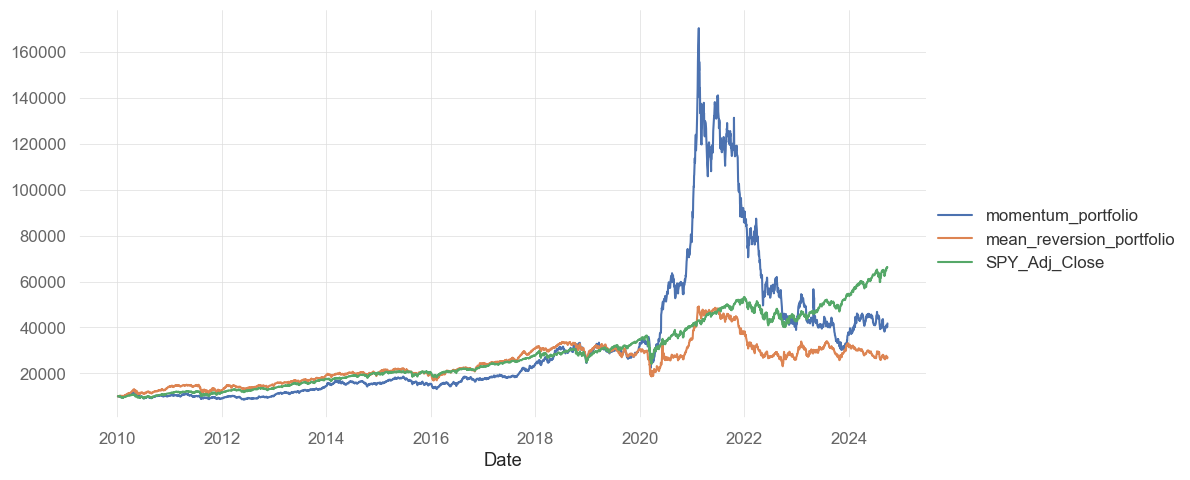

In [61]:
# display(sns.relplot(historical_performance_benchmark.loc[:,['Portfolio_Value','SPY_Adj_Close']], kind='line', dashes=False, aspect=2))#.set(yscale='log'))
display(sns.relplot(historical_performance_benchmark, kind='line', dashes=False, aspect=2))#.set(yscale='log'))


In [62]:
display(spy_data_adj_close.head())
display(historical_performance.head())
display(historical_performance_benchmark.head())

,SPY_Adj_Close
Date,
2010-01-04,10000.000000
2010-01-05,10026.471659
2010-01-06,10033.530415
2010-01-07,10075.885599
2010-01-08,10109.417782


,Portfolio_Value
Date,


,momentum_portfolio,mean_reversion_portfolio,SPY_Adj_Close
Date,,,
2010-01-04,10000.000000,10000.000000,10000.000000
2010-01-05,9900.236989,9895.610408,10026.471659
2010-01-06,9953.698468,9980.411581,10033.530415
2010-01-07,10027.335092,10091.402210,10075.885599
2010-01-08,10076.956002,10108.337493,10109.417782


In [63]:
historical_performance_benchmark['momentum_portfolio_returns'] = historical_performance_benchmark['momentum_portfolio'].pct_change()
historical_performance_benchmark['mean_reversion_portfolio_returns'] = historical_performance_benchmark['mean_reversion_portfolio'].pct_change()

historical_performance_benchmark['SPY_Returns'] = historical_performance_benchmark['SPY_Adj_Close'].pct_change()
# display(historical_performance_benchmark)

In [64]:
import portfolio_analytics
importlib.reload(portfolio_analytics)
from portfolio_analytics import make_stats_dataframe, make_mulit_stats_dataframe

In [65]:
str_v_date = {'str':0,'date':0}
for r in range(len(historical_performance_benchmark.index)):
    if type(historical_performance_benchmark.index[r])!=str:
        str_v_date['str']+=1
    else:
        str_v_date['date']+=1
        # historical_performance_benchmark.index[r] = historical_performance_benchmark.index[r].date()


In [66]:
make_mulit_stats_dataframe(historical_performance_benchmark,'SPY_Returns',['momentum_portfolio_returns','mean_reversion_portfolio_returns'])

,Annualized Return (CAGR),Volatility (Standard Deviation),Max Drawdown,Alpha,Beta,Sharpe Ratio,Sortino Ratio
Portfolio_Name,,,,,,,
mean_reversion_portfolio_returns,4.771,21.577,-53.038,0.0,1.0,0.421,0.604
momentum_portfolio_returns,6.925,27.647,-82.269,0.0,1.0,0.488,0.716
SPY_Returns,9.267,17.121,-33.717,0.0,1.0,0.837,1.173


In [67]:
trading_history_obj.add_analytics()

In [68]:
display(trading_history_obj.trades.info())


<class 'pandas.core.frame.DataFrame'>
Index: 4800 entries, GILT_2010-01-04 to BYON_2024-06-21
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Ticker                      4800 non-null   object        
 1   Entry_Date                  4800 non-null   datetime64[ns]
 2   Entry_Share_Price           4775 non-null   float64       
 3   Entry_Trading_Cost          4800 non-null   float64       
 4   Shares                      4800 non-null   float64       
 5   Exit_Date                   4680 non-null   datetime64[ns]
 6   Exit_Share_Price            4655 non-null   object        
 7   Exit_Trading_Cost           4680 non-null   object        
 8   Portfolio                   4800 non-null   object        
 9   Days_Held                   4680 non-null   float64       
 10  Return                      4655 non-null   object        
 11  Percent_Return              4655 non

None

In [69]:
historical_performance_benchmark_just_returns = historical_performance_benchmark.loc[:,['SPY_Returns','momentum_portfolio_returns','mean_reversion_portfolio_returns']]

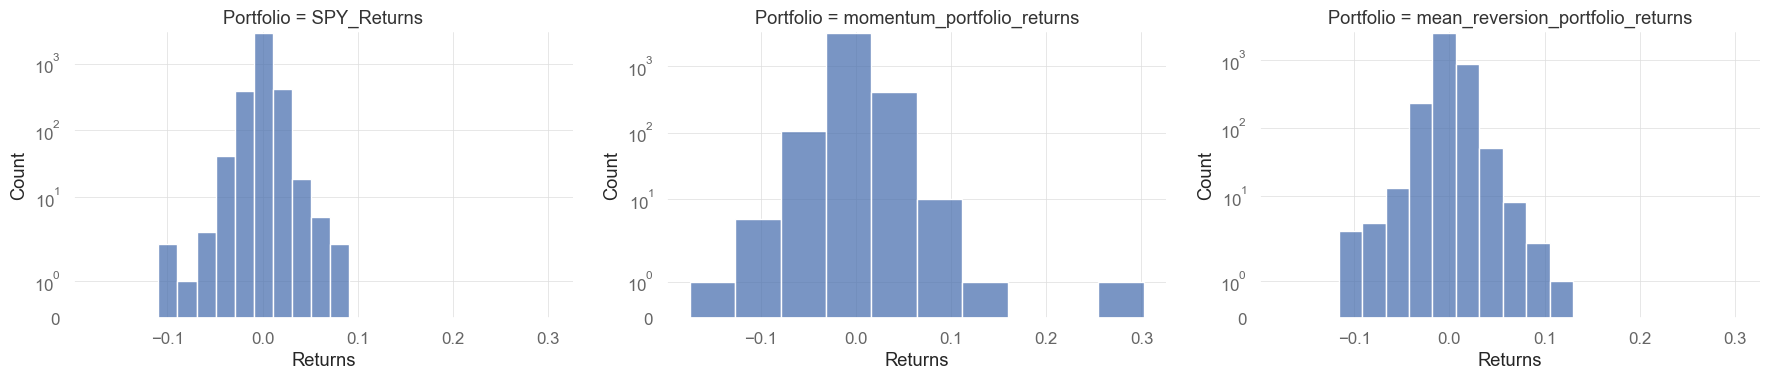

In [87]:
# return daily return frequency
g = sns.FacetGrid(historical_performance_benchmark_just_returns.melt(var_name='Portfolio',value_name='Returns'), col="Portfolio", sharey=False, height=4, aspect=1.5)
g.map(sns.histplot, "Returns", bins=10)
g.set(yscale='symlog')

In [ ]:
trades = trading_history_obj.trades#.melt(var_name='Portfolio',value_name='Annualized_Percent_Returns')
# sns.FacetGrid

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Technology'),
  Text(1, 0, 'Industrials'),
  Text(2, 0, 'Real Estate'),
  Text(3, 0, 'Finance'),
  Text(4, 0, 'Utilities'),
  Text(5, 0, 'Health Care'),
  Text(6, 0, 'Consumer Discretionary'),
  Text(7, 0, 'Basic Materials'),
  Text(8, 0, 'Energy'),
  Text(9, 0, 'Telecommunications'),
  Text(10, 0, 'Consumer Staples')])

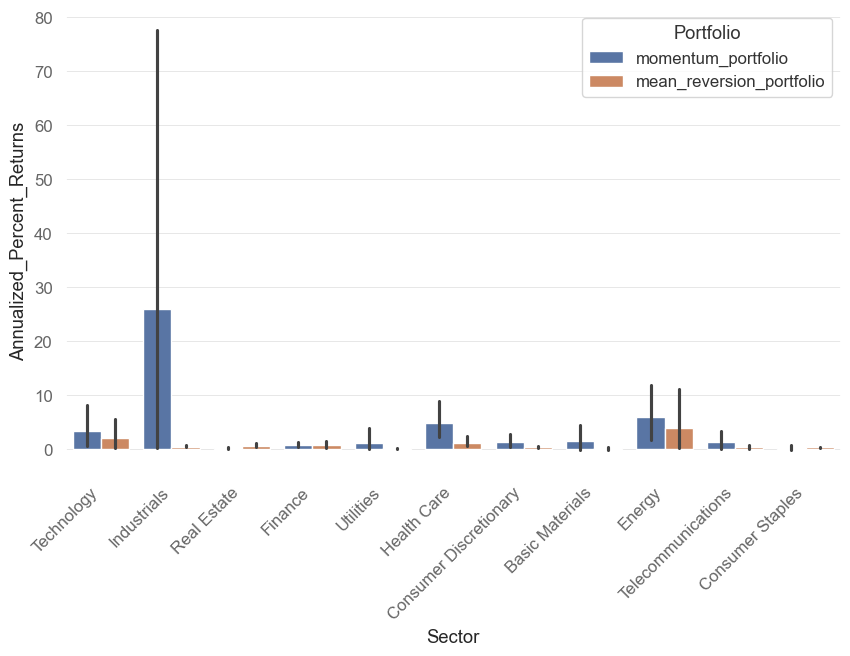

In [93]:
g = sns.barplot(data=trading_history_obj.trades,x='Sector',y='Annualized_Percent_Returns', hue='Portfolio',estimator='mean')
plt.xticks(rotation=45, ha="right")


In [72]:
# g = sns.barplot(x='Sector',y='Annualized_Percent_Returns',fac='Portfolio', data=trading_history_obj.trades)
# g = sns.catplot(data=trading_history_obj.trades,x='Sector',col='Portfolio',y='Annualized_Percent_Returns', kind='bar')

# plt.xticks(rotation=90)
# plt.show
# sns.displot(data=trading_history_obj.trades,x='Sector',y='Annualized_Percent_Returns',col='Portfolio')
# plt.xticks(rotation=45)

In [73]:
average_returns_by_sector_size = trading_history_obj.trades.groupby(['Portfolio','Sector','Size_Category_Entry'])['Annualized_Percent_Returns'].agg(['mean','min', 'max','std','count'])# .mean()
# average_returns_by_sector[average_returns_by_sector['Size_Category_Entry']=='mega']# or average_returns_by_sector['Size_Category_Entry']=='large']
display(average_returns_by_sector_size.sort_values(['Portfolio','mean']))

mean  \
Portfolio                Sector             Size_Category_Entry              
mean_reversion_portfolio Utilities          micro                -0.516171   
                         Basic Materials    mid                   -0.10609   
                                            large                -0.098976   
                         Telecommunications mid                  -0.056133   
                         Energy             mid                   0.030058   
...                                                                    ...   
momentum_portfolio       Basic Materials    micro                 4.874519   
                         Technology         small                 5.088757   
                         Health Care        micro                 8.942296   
                         Energy             micro                18.908371   
                         Industrials        small                48.094808   

                                                                      min  \
Portfolio                Sector             Size_Category_Entry             
mean_reversion_portfolio Utilities          micro               -0.995535   
                         Basic Materials    mid                 -0.855928   
                                            large               -0.780634   
                         Telecommunications mid                 -0.592835   
                         Energy             mid                 -0.874048   
...                                                                   ...   
momentum_portfolio       Basic Materials    micro               -0.778126   
                         Technology         small               -0.998431   
                         Health Care        micro               -0.999943   
                         Energy             micro               -0.831998   
                         Industrials        small               -0.962359   

                                                                         max  \
Portfolio                Sector             Size_Category_Entry                
mean_reversion_portfolio Utilities          micro                   0.269814   
                         Basic Materials    mid                     2.308936   
                                            large                   1.012467   
                         Telecommunications mid                     1.614045   
                         Energy             mid                      1.61807   
...                                                                      ...   
momentum_portfolio       Basic Materials    micro                  24.195029   
                         Technology         small                 628.684463   
                         Health Care        micro                1136.562435   
                         Energy             micro                 187.227946   
                         Industrials        small                5063.552023   

                                                                        std  \
Portfolio                Sector             Size_Category_Entry               
mean_reversion_portfolio Utilities          micro                  0.429982   
                         Basic Materials    mid                    0.724560   
                                            large                  0.539280   
                         Telecommunications mid                    0.520607   
                         Energy             mid                    0.541967   
...                                                                     ...   
momentum_portfolio       Basic Materials    micro                  9.981862   
                         Technology         small                 51.833521   
                         Health Care        micro                 72.654513   
                         Energy             micro                 48.910908   
                         Industrials        small               

In [74]:
average_returns_by_industry = trading_history_obj.trades.groupby(['Country'])['Annualized_Percent_Returns'].agg(['mean','min', 'max','std','count'])
pd.set_option('display.max_rows',150)
# display(average_returns_by_industry.sort_values(['mean']))
filtered_data = average_returns_by_industry[average_returns_by_industry['count'] > 5]
display(filtered_data.sort_values(['mean']))

,mean,min,max,std,count
Country,,,,,
Argentina,-0.324455,-0.84847,1.036354,0.520052,15
Australia,-0.253706,-0.903828,1.341318,0.648190,10
Peru,-0.064499,-0.685419,0.91697,0.459542,8
Germany,-0.062455,-0.814653,1.588805,0.674519,10
Cayman Islands,-0.021607,-0.998989,2.386317,0.905805,12
France,0.003499,-0.991831,2.180434,0.688579,19
Netherlands,0.017515,-0.679271,1.2608,0.535648,22
Chile,0.030901,-0.718175,1.553158,0.807787,6
Sweden,0.083949,-0.843361,2.626137,0.918279,19


In [75]:
company_data.value_counts('Sector')

Sector
Finance                   1522
Consumer Discretionary    1159
Health Care               1158
Technology                 752
Industrials                561
Real Estate                277
Energy                     183
Utilities                  174
Consumer Staples           145
Telecommunications         103
Basic Materials             87
Miscellaneous               63
Name: count, dtype: int64

In [76]:
company_data.value_counts('Industry')

Industry
Biotechnology: Pharmaceutical Preparations                        574
Major Banks                                                       308
Computer Software: Prepackaged Software                           258
Real Estate Investment Trusts                                     219
Industrial Machinery/Components                                   213
Blank Checks                                                      202
Investment Managers                                               191
Biotechnology: Biological Products (No Diagnostic Substances)     185
EDP Services                                                      171
Finance: Consumer Services                                        168
Medical/Dental Instruments                                        129
Business Services                                                 119
Trusts Except Educational Religious and Charitable                115
Oil & Gas Production                                              107
Semiconduct

In [77]:
company_data['Sector'].unique()

array(['Industrials', 'Real Estate', 'Finance', 'Health Care',
       'Consumer Discretionary', nan, 'Technology', 'Basic Materials',
       'Consumer Staples', 'Energy', 'Miscellaneous', 'Utilities',
       'Telecommunications'], dtype=object)

In [78]:
['Finance', 'Consumer Discretionary', 'Health Care', 'Technology', 'Industrials', 'Real Estate', 'Energy', 'Utilities', 'Consumer Staples', 'Telecommunications', 'Basic Materials', 'Miscellaneous']

['Finance',
 'Consumer Discretionary',
 'Health Care',
 'Technology',
 'Industrials',
 'Real Estate',
 'Energy',
 'Utilities',
 'Consumer Staples',
 'Telecommunications',
 'Basic Materials',
 'Miscellaneous']